In [49]:
# necessary imports
import numpy as np
import numpy.random as rng 
import tensorflow as tf
import matplotlib.pyplot as plt 
import sklearn.metrics
import keras.layers as layers
import keras.models
import scipy.stats
import keras.utils
import json
import pandas as pd

from graphviz import Source

In [4]:
with open('cars_data.json', 'r') as f:
    cars = json.load(f)
df = pd.DataFrame(cars)

KM_PER_LITER_PER_MILES_PER_GALLON = 0.425144

df['kpl'] = df['Miles_per_Gallon'] * KM_PER_LITER_PER_MILES_PER_GALLON
df['weight'] = df['Weight_in_lbs'] * 0.453592
df = df[~np.isnan(df['kpl']) & ~np.isnan(df['Horsepower'])]

In [38]:
X = np.array(df['Horsepower'])[:,np.newaxis]
y = np.array(df['kpl'])[:,np.newaxis]

N_HIDDEN = 3

input_node = layers.Input(shape=(X.shape[1],))
hidden_layer = layers.Dense(N_HIDDEN, activation='tanh')(input_node)
output_node = layers.Dense(1, activation='linear')(hidden_layer)
model = keras.models.Model(inputs=input_node, outputs=output_node)
model.compile('sgd', 'mean_squared_error')


In [46]:
# train the model
Xnormed = (X - np.mean(X)) / np.std(X)
ynormed = np.log(y)

weights = [
    model.get_weights()
]
EPOCHS_PER_REP = 10
REPS = 10
for r in range(REPS):
    model.fit(x = Xnormed, y=ynormed, verbose=False, epochs=EPOCHS_PER_REP, batch_size=X.shape[0] // 10)
    weights.append(model.get_weights())


In [62]:
for i, W in enumerate(weights):

    Wih, bh, Who, bo = W
    
    nWih = np.abs(Wih) * 2
    nbh = np.abs(bh) * 2
    nWho = np.abs(Who) * 2
    nbo = np.abs(bo) * 2
    
    graph = """
    digraph G {
            graph [dpi=300];
            rankdir=LR
        splines=line
            nodesep=.05;

            node [label="", width=0.5, fixedsize=true, penwidth=2];

            subgraph cluster_0 {
            color=white;
                    node [style=solid,color=blue4, shape=circle];
            x1 x2;
            label = "Input Layer";
        }

        subgraph cluster_1 {
            color=white;
            node [style=solid,color=red2, shape=circle];
            a12 a22 a32 a42;
            label = "Hidden Layer";
        }

        subgraph cluster_2 {
            color=white;
            node [style=solid,color=seagreen2, shape=circle];
            y;
            label="Output Layer";
        }

            x1 [label=1]
            x2 [label=HP]
            a12 [label=1]
            a22 [label=<h<sub>1</sub>>]
            a32 [label=<h<sub>2</sub>>]
            a42 [label=<h<sub>3</sub>>]
            y [label=KPL]

            x1 -> a22 [penwidth=%0.2f];
            x1 -> a32 [penwidth=%0.2f];
            x1 -> a42 [penwidth=%0.2f];


            x2 -> a22  [penwidth=%0.2f];
            x2 -> a32  [penwidth=%0.2f];
            x2 -> a42  [penwidth=%0.2f];


            a12 -> y [penwidth=%0.2f]
            a22 -> y [penwidth=%0.2f]
            a32 -> y [penwidth=%0.2f]
            a42 -> y [penwidth=%0.2f]



    }
    """ % (nbh[0], nbh[1], nbh[2], nWih[0, 0], nWih[0, 1], nWih[0, 2], nbo[0], nWho[0, 0], nWho[])
    dot = Source(graph)
    dot.render(filename='../tmp/intermediate_net_%d' % i, format='png')

No handles with labels found to put in legend.


MSE: 72.006822


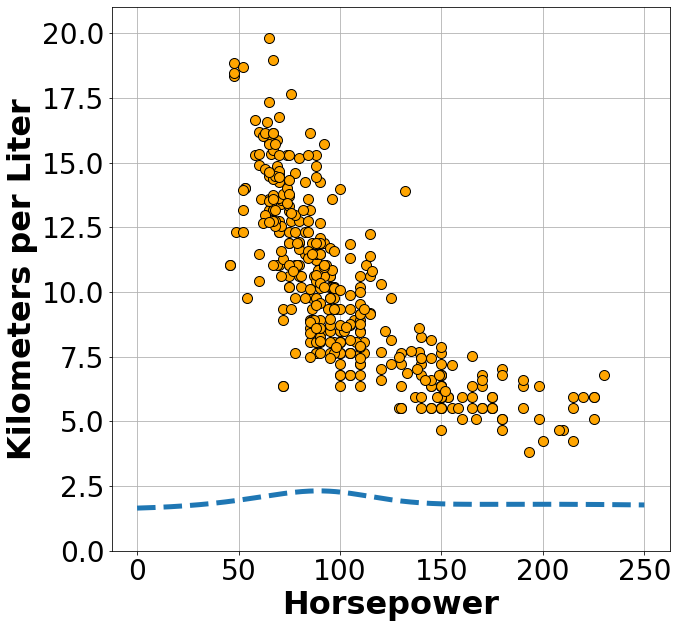

In [41]:
hps = np.linspace(0, 250, 1000)[:,np.newaxis]
log_kpls = model.predict((hps - np.mean(X))/np.std(X))

mse = np.mean(np.square(np.exp(model.predict(Xnormed)) - y))
print("MSE: %f" % mse)
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(df['Horsepower'], df['kpl'], marker='o', linestyle='', markersize=10, color='orange', markeredgecolor='black')

ax.plot(hps, np.exp(log_kpls), linewidth=5, linestyle='--')
ax.tick_params(axis='x', labelsize=28)
ax.tick_params(axis='y', labelsize=28)
ax.set_ylabel('Kilometers per Liter', fontsize=32, fontweight='bold')
ax.set_xlabel('Horsepower', fontsize=32, fontweight='bold')
ax.grid('both')
ax.set_ylim([0, 21])
ax.legend(fontsize=24, frameon=False)
plt.savefig('../tmp/nn_fit.png', bbox_inches='tight')
